# Analysis of Bumpless PI Controller

In [2]:
# Set default parameters for publication quality plots
import matplotlib.pyplot as plt
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', linewidth=3)

## Closed-Loop Dynamics

## Simulation

In [3]:
import numpy as np

# parameters
T_amb = 21 # deg C
alpha = 0.00016 # watts / (units P1 * percent U1)
P1 = 100 # P1 units
U1 = 50 # steady state value of u1 (percent)

# fitted parameters (see previous lab) for hardware
'''
Ua = 0.0261 # watts/deg C
Ub = 0.0222 # watts/deg C
CpH = 1.335 # joules/deg C
CpS = 1.328 # joules/deg C
'''

# fitted parameters (repeat Lab 3) for TCLab digital twin
Ua = 0.05 # watts/deg C
Ub = 0.05 # watts/deg C
CpH = 5.0 # joules/deg C
CpS = 1.0 # joules/deg C

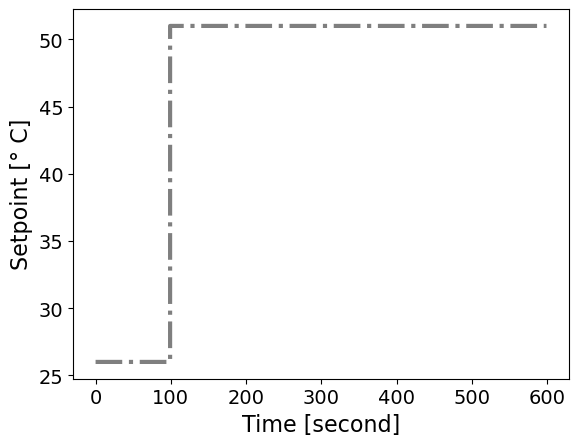

In [4]:
t = np.arange(0, 600, 1)
T_set = np.ones(t.shape)*5
T_set[100:] = 30

plt.step(t, T_set + T_amb, linestyle='-.', color='black', alpha=0.5)
plt.xlabel('Time [second]')
plt.ylabel('Setpoint [° C]')
plt.show()

### Continuous Simulation

### Discrete Simulation

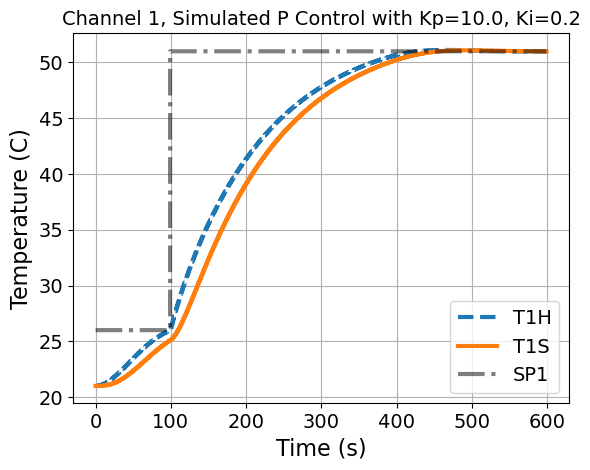

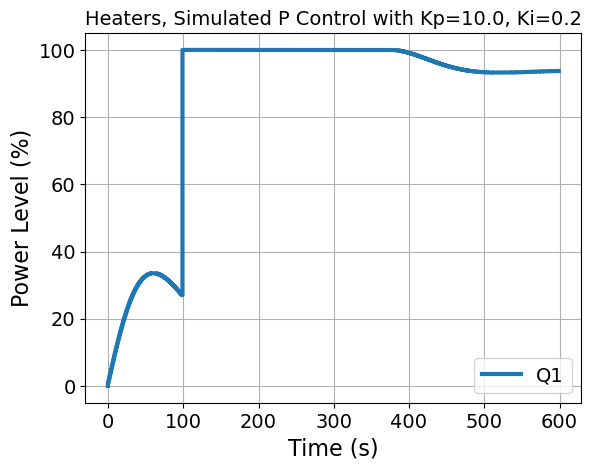

,T1H,T1S,Time,Q1,SP1
0,21.000000,21.000000,0,0.000000,26.0
1,21.000000,21.000000,1,1.000000,26.0
2,21.003168,21.000078,2,1.999203,26.0
3,21.009442,21.000384,3,2.996071,26.0
4,21.018754,21.001055,4,3.989146,26.0
...,...,...,...,...,...
595,50.984636,50.990960,595,93.702318,51.0
596,50.984699,50.990653,596,93.707256,51.0
597,50.984772,50.990365,597,93.712069,51.0
598,50.984857,50.990094,598,93.716757,51.0


In [15]:
import pandas as pd
from scipy.signal import cont2discrete


def tclab_simulate_bumpless_PI(Kp = 1.0, Ki = 0.05, verbose=False, plot=True):
    ''' Simulate the TCLab system with PI control
    Arguments:
        Kp: the proportional control gain
        Ki: the integral control gain
        verbose: print matrices, default is False
        plot: create plots, default is True

    Returns:
        data: DataFrame with columns for Time, T1, T2, Q1, Q2
    '''

    n = len(t)

    assert len(T_set) == n, 'Setpoint array must have the same length as time array'

    # Original open loop state space model
    A = np.array([[-(Ua + Ub)/CpH, Ub/CpH], [Ub/CpS, -Ub/CpS]])
    B = np.array([[alpha*P1/CpH], [0]])
    C = np.array([[0, 1]])
    D = np.array([[0]])

    Ad, Bd, Cd, Dd, dt = cont2discrete((A, B, C, D), dt=1, method='zoh')

    # Initialize state matrix
    X = np.zeros((n, 2))

    # Initialize input matrix
    U = np.zeros((n, 1))

    prev_error = 0


    # Loop over time steps
    for i in range(n):
    

        # Current state
        x = X[i, :]

        # Unpack into individual states
        T1H, T1S = x

        error = T_set[i] - T1S

        if i > 0:
            dt = t[i] - t[i-1]
            U[i,0] = U[i-1,0] + Kp*(error-prev_error) +  dt*Ki*(error)

        # Limit the power levels
        U[i, 0] = max(0, min(100, U[i, 0]))

        # Update state
        if i < n-1:
            # Do not update the state for the last time step
            # We want to update U and SP for plotting
            X[i + 1, :] = Ad @ x + Bd @ U[i, :]

        prev_error = error


    # Shift states from deviation variables to absolute values
    X += T_amb

    # Create DataFrame
    data = pd.DataFrame(X, columns=['T1H', 'T1S'])
    data['Time'] = t
    data['Q1'] = U[:, 0]
    data['SP1'] = T_set + T_amb

    if plot:
        plt.title('Channel 1, Simulated P Control with Kp={}, Ki={}'.format(Kp,Ki))
        plt.step(data['Time'], data['T1H'], label='T1H', linestyle='--')
        plt.step(data['Time'], data['T1S'], label='T1S', linestyle='-')
        plt.step(data['Time'], data['SP1'], label='SP1', linestyle='-.', color='black', alpha=0.5)
        plt.ylabel('Temperature (C)')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.grid()
        plt.show()
        

        plt.title('Heaters, Simulated P Control with Kp={}, Ki={}'.format(Kp,Ki))
        plt.step(data['Time'], data['Q1'], label='Q1')
        plt.xlabel('Time (s)')
        plt.ylabel('Power Level (%)')
        plt.legend()
        plt.grid()
        plt.show()

    return data

tclab_simulate_bumpless_PI(Kp=10.0, Ki=0.2)

## Stability Analysis